<a href="https://colab.research.google.com/github/maxigit42/stock-prediction-GRU/blob/main/stock-prediction-GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from ta.trend import MACD

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU


In [6]:
#Cargar datos
company = 'AMZN'
ticker = yf.Ticker(company)
hist = ticker.history(start = '2012-1-1', end='2021-1-1')


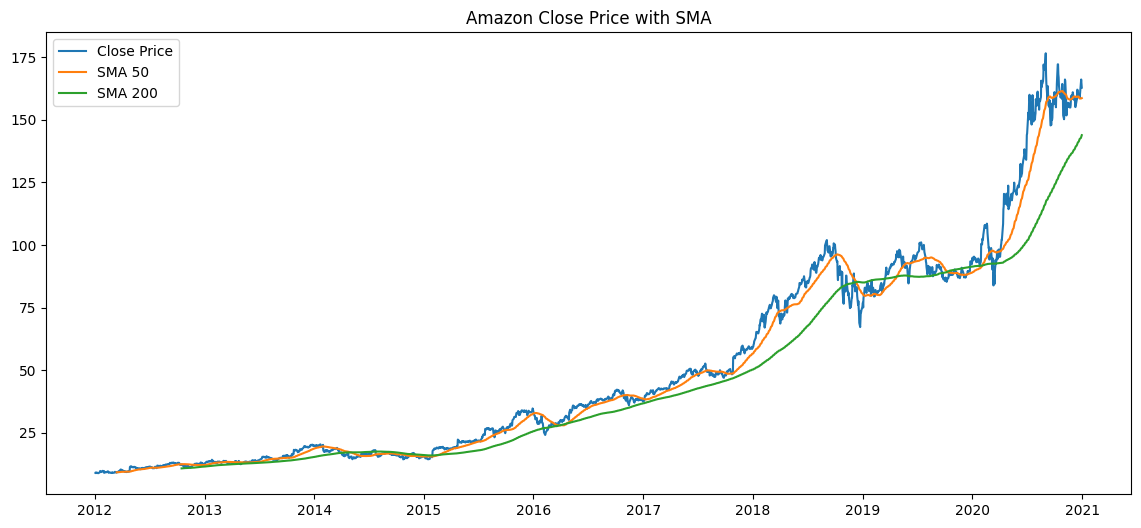

In [7]:
df = hist.copy()

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df['sma_50'] = ta.trend.sma_indicator(df['Close'], window=50)
df['sma_200'] = ta.trend.sma_indicator(df['Close'], window=200)

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['sma_50'], label='SMA 50')
plt.plot(df['sma_200'], label='SMA 200')
plt.title('Amazon Close Price with SMA')
plt.legend()
plt.show()


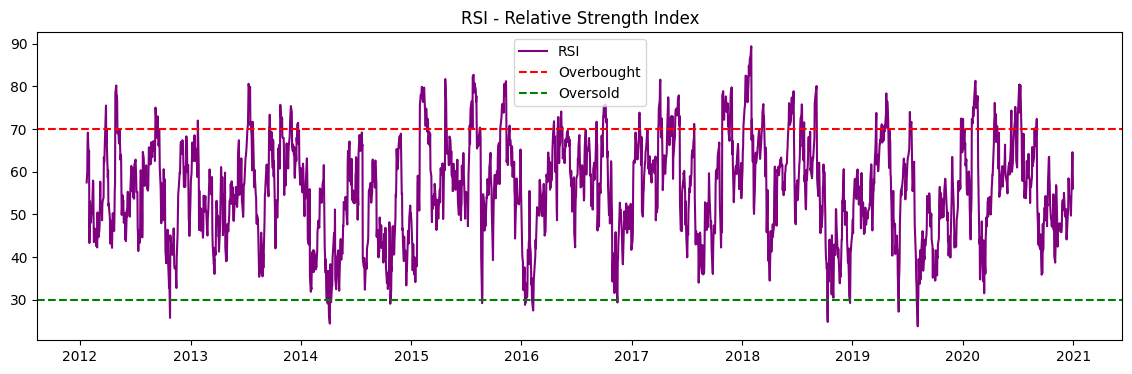

In [8]:
df['rsi'] = ta.momentum.rsi(df['Close'], window=14)

plt.figure(figsize=(14,4))
plt.plot(df['rsi'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('RSI - Relative Strength Index')
plt.legend()
plt.show()

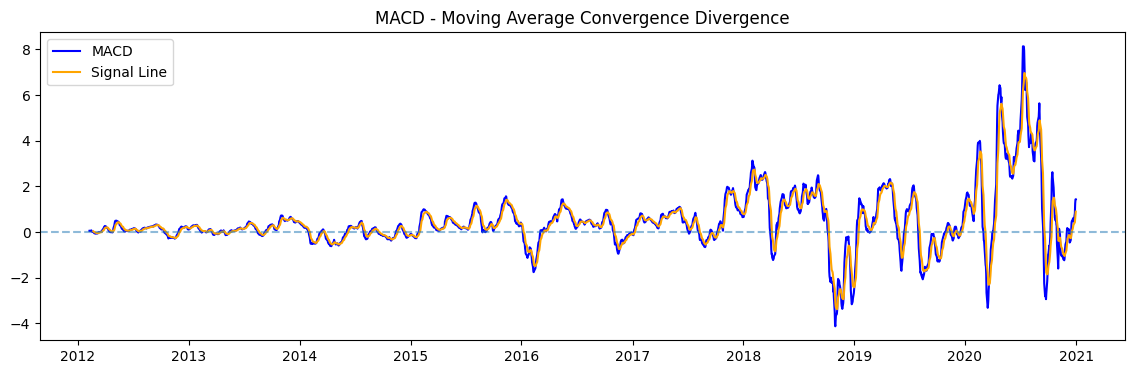

In [15]:
macd = MACD(close=df['Close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

plt.figure(figsize=(14,4))
plt.plot(df['macd'], label='MACD', color='blue')
plt.plot(df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, linestyle='--', alpha=0.5)
plt.title('MACD - Moving Average Convergence Divergence')
plt.legend()
plt.show()

In [ ]:
#Preparar los datos para que sean legibles por la red neuronal
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(hist['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x,0])
  y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))

x_train.shape  #Poner en 3d la variable x_train

(2205, 60, 1)

In [ ]:
#Construir modelo
model = Sequential()

model.add(GRU(units=50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - loss: 0.0277
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0011
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0013
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0012
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 0.0010
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0010
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0011
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 9.5452e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 7.0685e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 9.5022e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 7.9717e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 7.0362e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 6.5491e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 6.8678e-04
Epoch 15/25
69/69 ━━

In [ ]:
#Cargar los datos del test
hist_test = ticker.history(start= '2020-1-1', end='2025-07-26')
actual_prices = hist_test["Close"].values

total_dataset = pd.concat((hist['Close'],hist_test['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(hist_test)- prediction_days:].values
model_inputs = scaler.transform(model_inputs.reshape(-1,1))


In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predict_prices = model.predict(x_test)
predict_prices = scaler.inverse_transform(predict_prices)

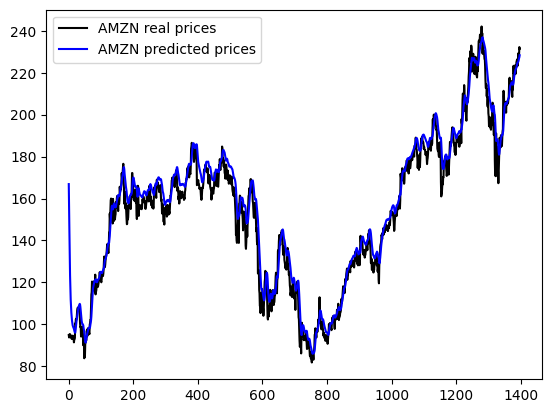

In [ ]:
plt.plot(actual_prices,color="black",label=f"{company} real prices")
plt.plot(predict_prices,color="blue",label=f"{company} predicted prices")
plt.legend()
plt.show()

In [ ]:
rentability = 1
for i in range(1, len(actual_prices)):
  if predict_prices[i] > actual_prices[i-1]:
    rentability*= actual_prices[i]/actual_prices[i-1]

print((rentability-1)* 100, "%")

103.79569714188986 %
